# Injections

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
plt.rcParams["figure.figsize"] = (14, 10)
from tess_stars2px import tess_stars2px_function_entry
import eleanor
import tess_rotation as tr

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mag_to_counts(mag, seconds):
    """
    Convert stellar magnitude to electron counts.
    
    "15,000 e−/s for a star of m = 10: thus, a star of m = 5 will create 3 × 106 electrons in a two-second exposure"
    10 x fainter is a magnitude increase of 2.5 
    
    F2/F1 approx 2.5^(delta m)
    delta m = 1
    F2/F1 = 2.5
    
    delta m = log(F2/F1)/log(2.5)
    for F2/F1 = 10, delta m = 2.5
    
    For a change of 1 mag, the change in brightness is 2.5.
    For a change of 2.5 mag, the change in brightness is 10.
    For a change of 5 mag, the change in brightness is 100.
    """
    m = 10
    e = 15000
    delta_m = m - mag
    factor = 2.51**delta_m
    counts_per_sec = e * factor
    return counts_per_sec * seconds

print(mag_to_counts(15, 2))

301.1290453376505


In [3]:
df = pd.read_csv("../../data/really_faint_cvz_ruthangus.csv")

In [4]:
# for k in df.keys():
#     print(k)
print(df.Tmag.values[3])
print(df.ID.values[3])

19.971399307251
765143490


In [115]:
# ticid = "349061281"
ticid = df.ID.values[3]  # 1 is a maybe, but it's close to another star. 2 seems to be bright?
sectors, _ = tr.get_sectors(ticid, upper_sector_limit=14)
print(sectors)

[ 1  2  4  5  6  7  8  9 10 11 12]


In [117]:
tr.download_tess_cuts(ticid, lower_sector_limit=0, upper_sector_limit=14)

INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
Inflating...
No cached file found. Downloading /Users/rangus/projects/TESS-rotation/data/TESScut/astrocut_118.422867984028_-65.8036343895576_68x68px/tess-s0001-4-3_118.422868_-65.803634_68x68_astrocut.fits
Inflating...
Inflating...
No cached file found. Downloading

In [118]:
tesscut_path = "/Users/rangus/projects/TESS-rotation/data/TESScut/"
sector = sectors[0]
star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
filename = tr.get_fits_filenames(tesscut_path, sector, star.camera, star.chip, star.coords[0], star.coords[1])
injected_filename = f"{filename[:-5]}_injected.fits"

In [119]:
hdul = fits.open(filename)
postcard = hdul[1].data
cols = hdul[1].columns

(1282, 68, 68)


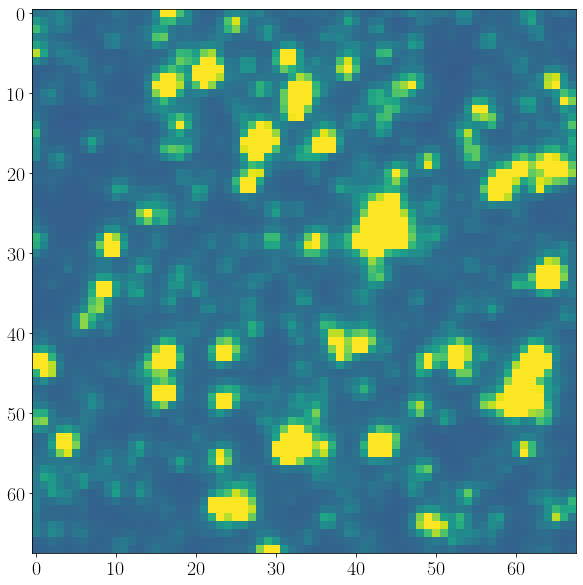

In [120]:
time = postcard["TIME"]*1.
flux = postcard["FLUX"]*1.
print(np.shape(flux))

plt.imshow(flux[0, ::-1, :], vmin=0, vmax=300)

Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array
(1267, 68, 68) shape
[33, 35] [33, 35]


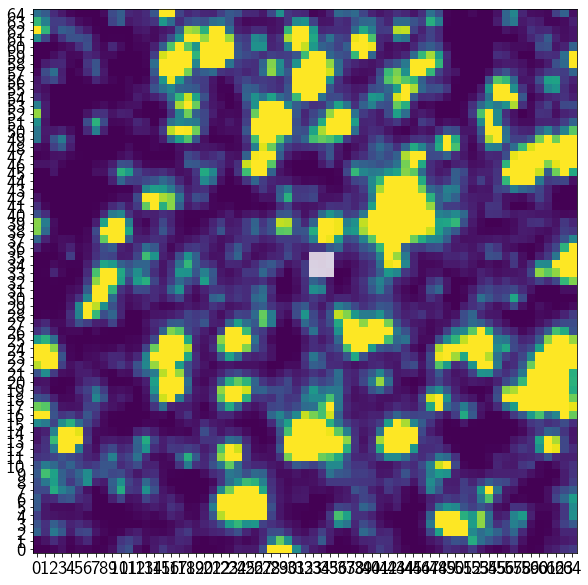

([33, 35], [33, 35], <Figure size 1008x720 with 1 Axes>)

In [121]:
tr.select_aperture(sector, [33, 35], [33, 35], filename, plot=True)

In [149]:
import os
def inject_signal(ticid, period, amplitude, baseline, tesscut_path,
                  lower_sector_limit=0, upper_sector_limit=14, xpix=68, ypix=68):
    
    sectors, star = tr.get_sectors(ticid, lower_sector_limit=lower_sector_limit,
                                   upper_sector_limit=upper_sector_limit)

    # Eleanor object
    print("Finding Eleanor object...")
    for sector in sectors:
        print("sector", sector)

        print(ticid, sector)
        star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
        sec, camera, ccd, colrowpix = star.sector, star.camera, star.chip, star.position_on_chip
        ra, dec = star.coords
        
        fits_file = tr.get_fits_filenames(tesscut_path, sector, camera, ccd, ra, dec)
        
        path_to_tesscut = "{0}/astrocut_{1:12}_{2:13}_{3}x{4}px".format(tesscut_path, ra, dec, xpix, ypix)
        inj_dir = "{0}/injected".format(path_to_tesscut)
        if not os.path.exists(inj_dir):
            os.mkdir(inj_dir)
        injection_filename = \
        "{0}/tess-s{1}-{2}-{3}_{4:.6f}_{5:.6f}_{6}x{7}_astrocut.fits".format(
            inj_dir, str(int(sector)).zfill(4), camera, ccd, ra, dec, xpix, ypix)

        tr.inject_one_sector(ticid, sector, period, amplitude, baseline, sec,
                             camera, ccd, colrowpix, fits_file, injection_filename)

baseline = mag_to_counts(15, 2)
period, amplitude = 50, 3
inject_signal(ticid, period, amplitude, baseline, tesscut_path)

INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
Finding Eleanor object...
sector 1
765143490 1
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 2
765143490 2
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 4
765143490 4
Loading TESScut FFI...
Fetching PRF.

In [150]:
def CPM_recover(ticid, tesscut_path, lower_sector_limit=0,
                upper_sector_limit=1000):

    print("Searching for observed sectors...")
    sectors, star = tr.get_sectors(ticid,
                                   lower_sector_limit=lower_sector_limit,
                                   upper_sector_limit=upper_sector_limit)
    print("sectors found: ", sectors)

    print("Creating light curve..")
    xs, ys = [], []
    for sector in sectors:
        print("sector", sector)
        star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
        x, y = CPM_one_sector(ticid, tesscut_path, sector, star.camera,
                              star.chip, star.coords[0], star.coords[1])
        xs.append(x)
        ys.append(y)

    return xs, ys, sectors

def CPM_one_sector(ticid, tesscut_path, sector, camera, ccd, ra, dec, xpix=68, ypix=68):
    fits_file = tr.get_fits_filenames(tesscut_path, sector, camera, ccd, ra, dec,
                                      xpix=xpix, ypix=ypix)    
    path_to_tesscut = "{0}/astrocut_{1:12}_{2:13}_{3}x{4}px".format(tesscut_path, ra, dec, xpix, ypix)
    inj_dir = "{0}/injected".format(path_to_tesscut)
    injected_filename = "{0}/tess-s{1}-{2}-{3}_{4:.6f}_{5:.6f}_{6}x{7}_astrocut.fits".format(
        inj_dir, str(int(sector)).zfill(4), camera, ccd, ra, dec, xpix, ypix)

    # Create CPM light curve
    x, y = tr.make_lc_single_sector(sector, [33, 35], [33, 35], injected_filename,
                                    plot=False, save_to_file=False)
    return x, y

In [151]:
time_cpm, flux_cpm, sectors = CPM_recover(ticid, tesscut_path, lower_sector_limit=0, upper_sector_limit=14)

Searching for observed sectors...
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
sectors found:  [ 1  2  4  5  6  7  8  9 10 11 12]
Creating light curve..
sector 1
Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves
Summing over 3 x 3 pixel lightc

In [152]:
time, flux, flux_err = tr.stitch_light_curve(ticid, time_cpm, flux_cpm)

Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
132it [00:00, 680.82it/s, logp=4.205340e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 523.8426525573116 -> 4205.340178936562


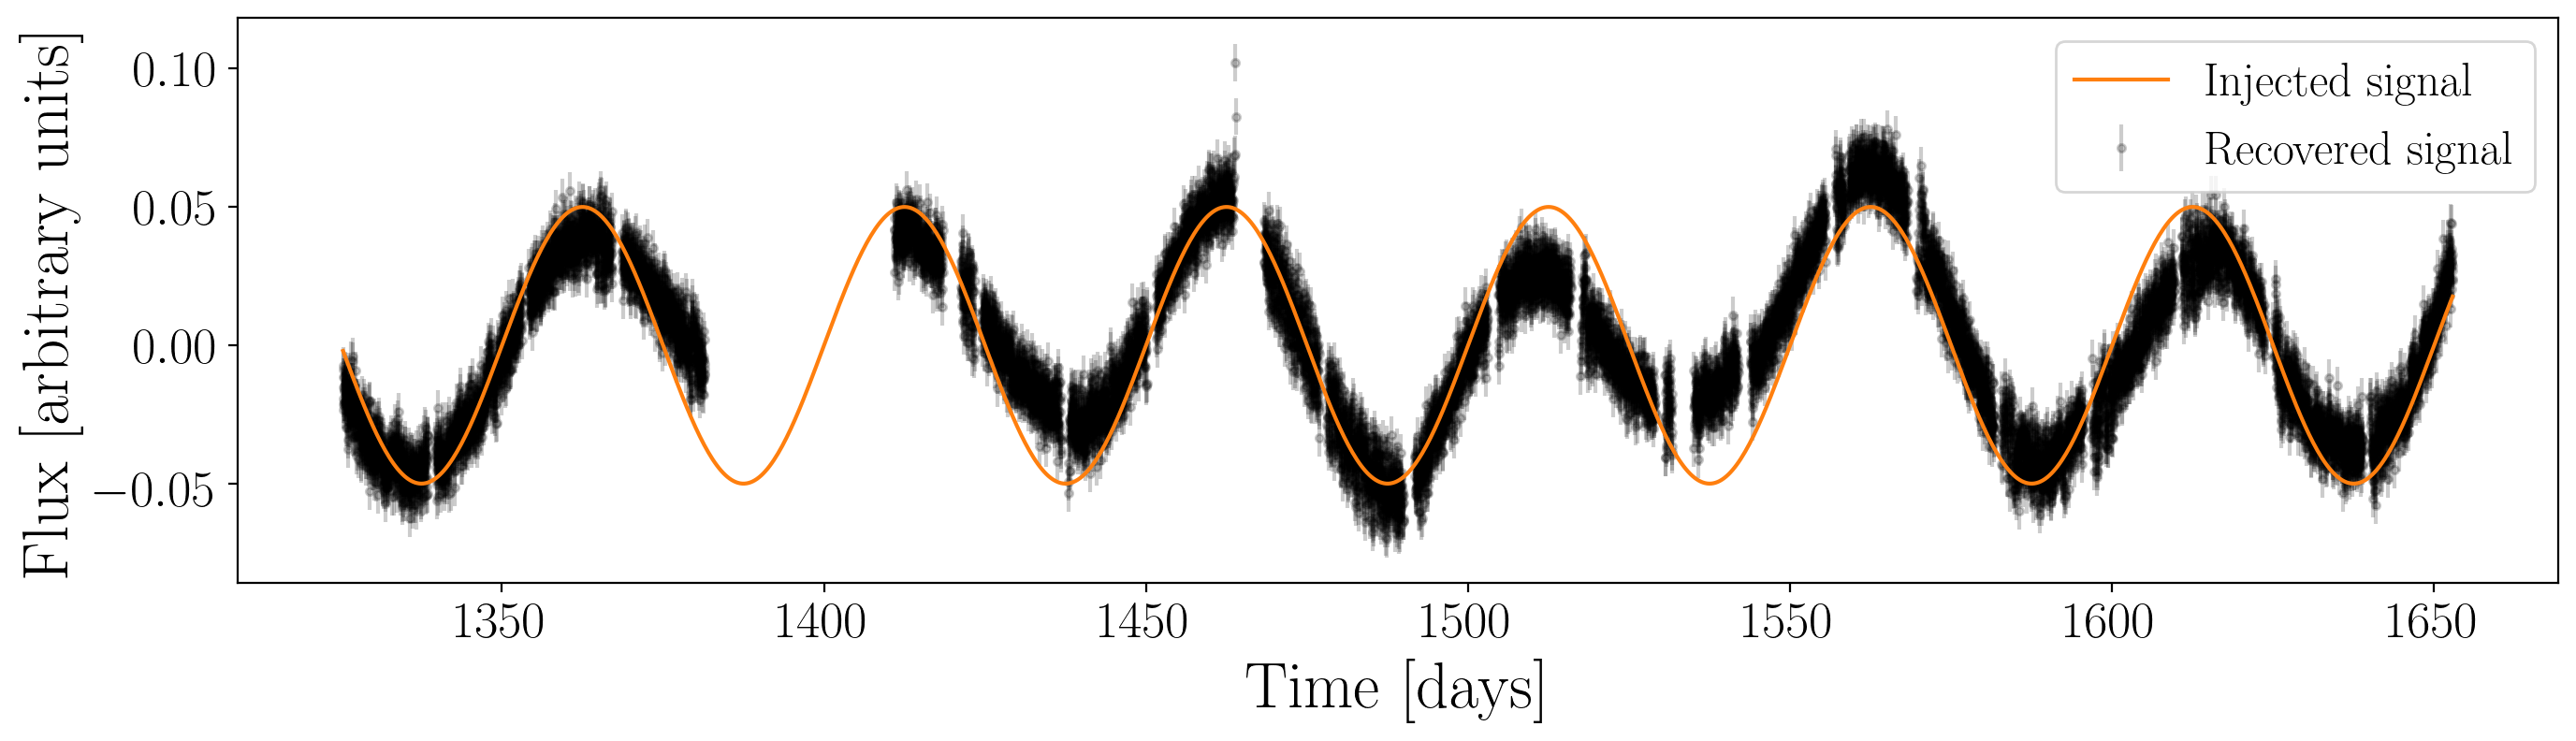

In [170]:
plt.figure(figsize=(16, 4), dpi=200)
p = np.polyfit(time, flux, 1)
xs = np.linspace(min(time), max(time), 1000)
plt.errorbar(time, flux-np.polyval(p, time), yerr=flux_err, fmt="k.", alpha=.2, label="$\mathrm{Recovered~signal}$")
plt.plot(xs, 0.05*np.sin(xs*2*np.pi/50), "C1", zorder=10, label="$\mathrm{Injected~signal}$")
plt.legend(fontsize=18)
plt.xlabel("$\mathrm{Time~[days]}$")
plt.ylabel("$\mathrm{Flux~[arbitrary~units]}$");
plt.savefig("15th_50_day_injection")
plt.savefig("15th_50_day_injection.pdf")

In [168]:
baseline = mag_to_counts(15, 2)
period, amplitude = 100, 3
inject_signal(ticid, period, amplitude, baseline, tesscut_path)

INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
Finding Eleanor object...
sector 1
765143490 1
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 2
765143490 2
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 4
765143490 4
Loading TESScut FFI...
Fetching PRF.

In [169]:
time_cpm100, flux_cpm100, sectors = CPM_recover(ticid, tesscut_path, lower_sector_limit=0, upper_sector_limit=14)

Searching for observed sectors...
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
sectors found:  [ 1  2  4  5  6  7  8  9 10 11 12]
Creating light curve..
sector 1
Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves
Summing over 3 x 3 pixel lightc

In [171]:
time100, flux100, flux_err100 = tr.stitch_light_curve(ticid, time_cpm100, flux_cpm100)

Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
99it [00:00, 683.64it/s, logp=4.283909e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.1049426404168 -> 4283.90861585745


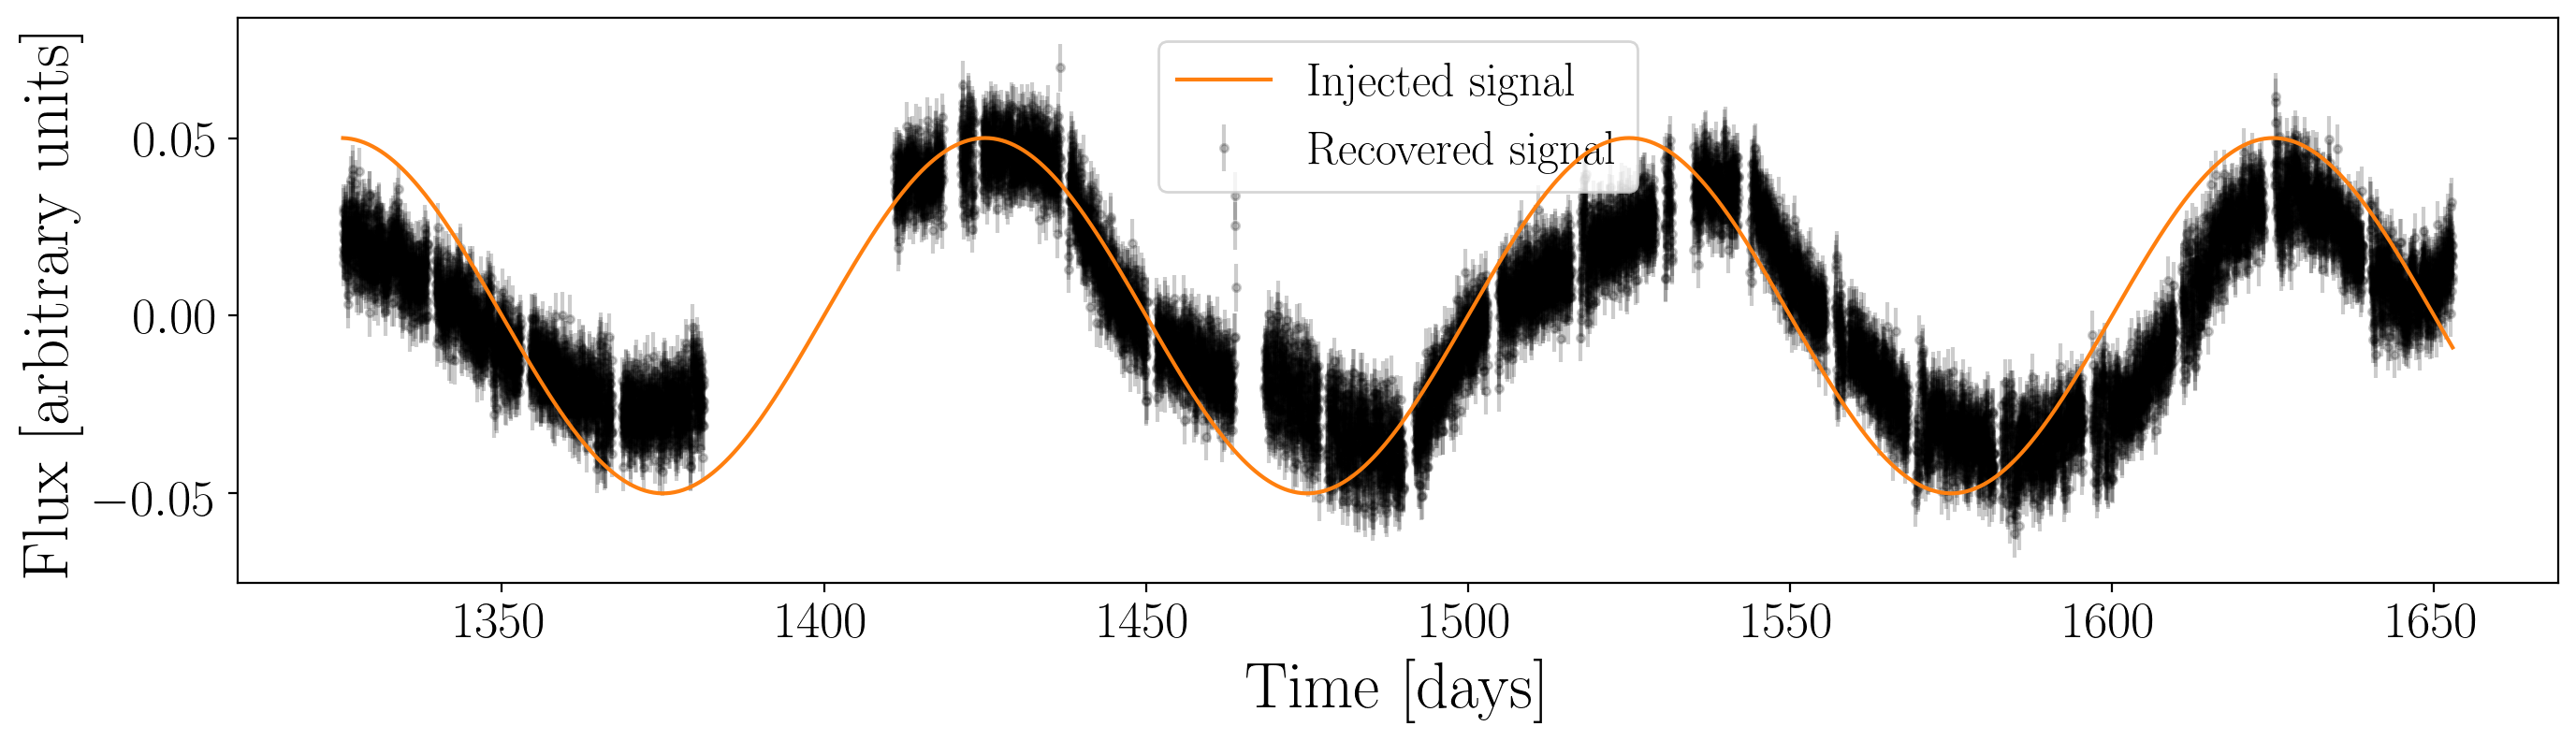

In [175]:
plt.figure(figsize=(16, 4), dpi=200)
p = np.polyfit(time100, flux100, 1)
xs = np.linspace(min(time100), max(time100), 1000)
plt.errorbar(time100, flux100-np.polyval(p, time100), yerr=flux_err100, fmt="k.", alpha=.2, label="$\mathrm{Recovered~signal}$")
plt.plot(xs, 0.05*np.sin(xs*2*np.pi/100), "C1", zorder=10, label="$\mathrm{Injected~signal}$")
plt.legend(loc="upper center", fontsize=18)
plt.xlabel("$\mathrm{Time~[days]}$")
plt.ylabel("$\mathrm{Flux~[arbitrary~units]}$");
plt.savefig("15th_100_day_injection")
plt.savefig("15th_100_day_injection.pdf")

In [176]:
baseline = mag_to_counts(15, 2)
period, amplitude = 200, 3
inject_signal(ticid, period, amplitude, baseline, tesscut_path)

INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
Finding Eleanor object...
sector 1
765143490 1
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 2
765143490 2
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 4
765143490 4
Loading TESScut FFI...
Fetching PRF.

In [177]:
time_cpm200, flux_cpm200, sectors = CPM_recover(ticid, tesscut_path, lower_sector_limit=0, upper_sector_limit=14)

Searching for observed sectors...
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
sectors found:  [ 1  2  4  5  6  7  8  9 10 11 12]
Creating light curve..
sector 1
Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves
Summing over 3 x 3 pixel lightc

In [178]:
time200, flux200, flux_err200 = tr.stitch_light_curve(ticid, time_cpm200, flux_cpm200)

Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
122it [00:00, 616.07it/s, logp=4.247556e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.4796838181733 -> 4247.555539499249


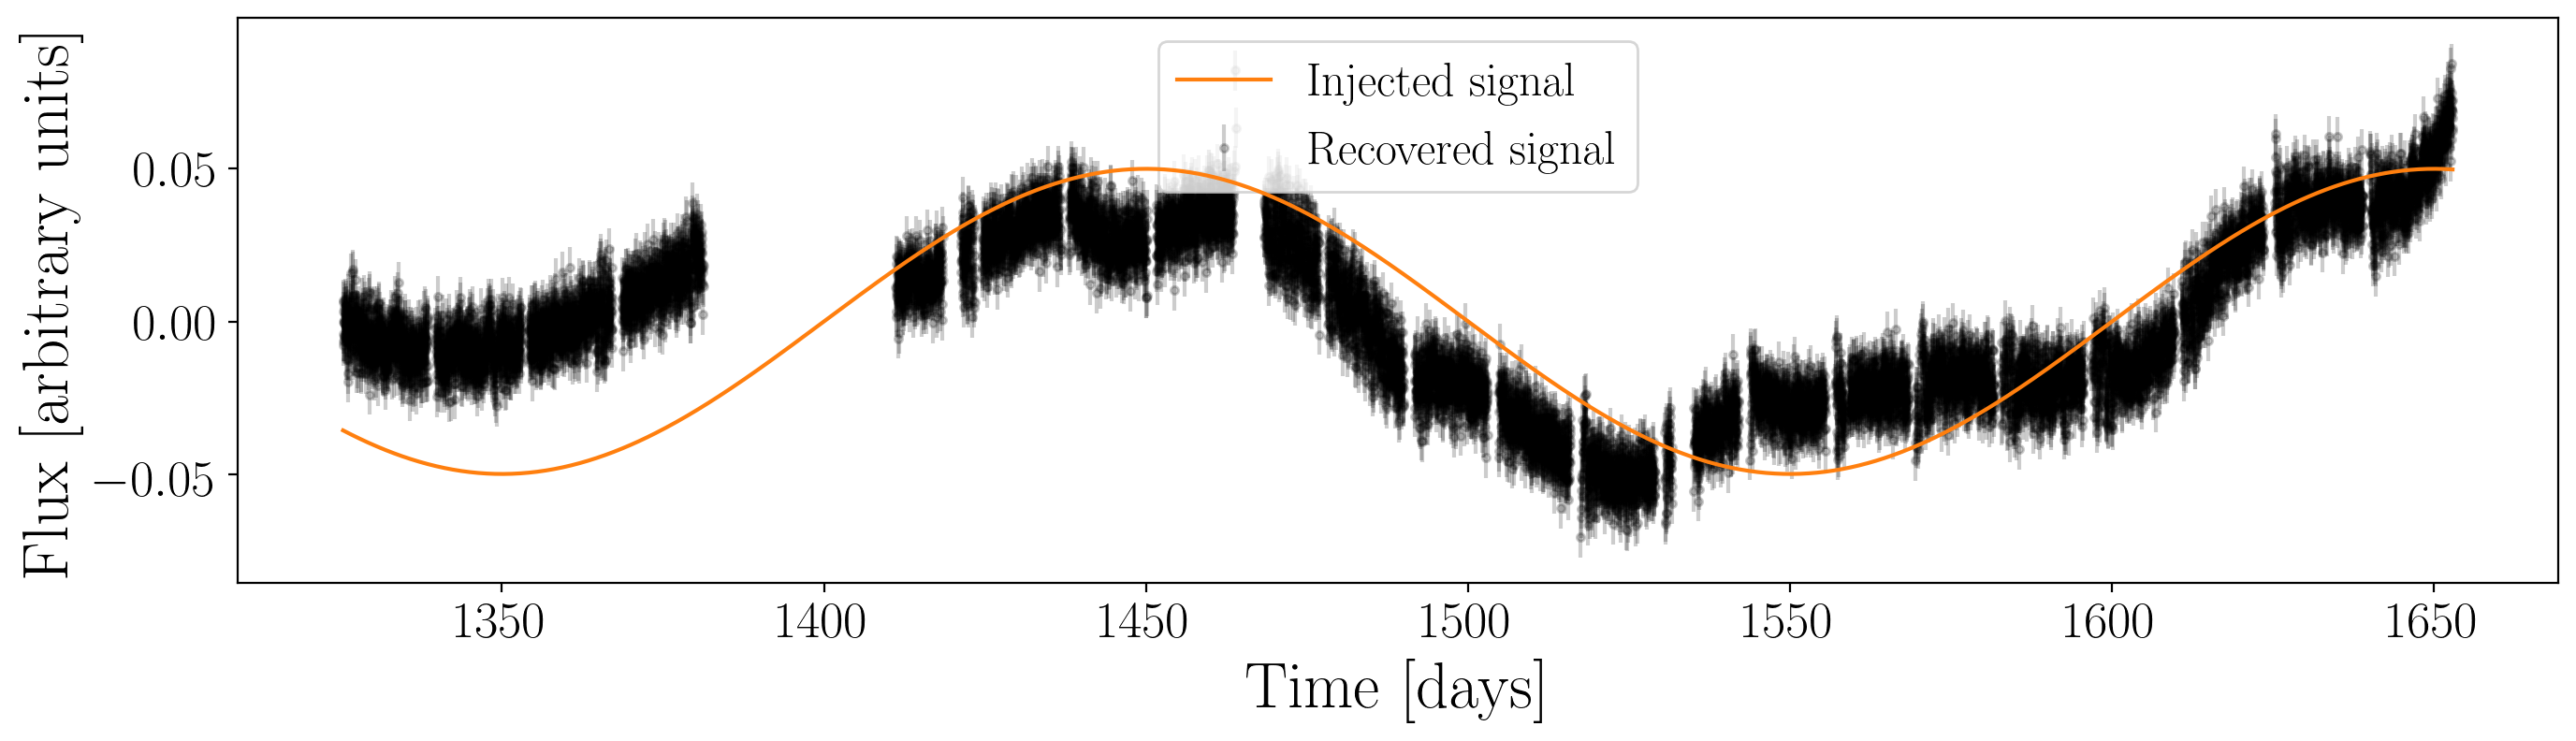

In [179]:
plt.figure(figsize=(16, 4), dpi=200)
p = np.polyfit(time200, flux200, 1)
xs = np.linspace(min(time200), max(time200), 1000)
plt.errorbar(time200, flux200-np.polyval(p, time200), yerr=flux_err200, fmt="k.", alpha=.2, label="$\mathrm{Recovered~signal}$")
plt.plot(xs, 0.05*np.sin(xs*2*np.pi/200), "C1", zorder=10, label="$\mathrm{Injected~signal}$")
plt.legend(loc="upper center", fontsize=18)
plt.xlabel("$\mathrm{Time~[days]}$")
plt.ylabel("$\mathrm{Flux~[arbitrary~units]}$");
plt.savefig("15th_200_day_injection")
plt.savefig("15th_200_day_injection.pdf")

In [180]:
baseline = mag_to_counts(15, 2)
period, amplitude = 150, 3
inject_signal(ticid, period, amplitude, baseline, tesscut_path)

INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
Finding Eleanor object...
sector 1
765143490 1
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 2
765143490 2
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 4
765143490 4
Loading TESScut FFI...
Fetching PRF.

In [181]:
time_cpm150, flux_cpm150, sectors = CPM_recover(ticid, tesscut_path, lower_sector_limit=0, upper_sector_limit=14)

Searching for observed sectors...
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
sectors found:  [ 1  2  4  5  6  7  8  9 10 11 12]
Creating light curve..
sector 1
Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves
Summing over 3 x 3 pixel lightc

In [182]:
time150, flux150, flux_err150 = tr.stitch_light_curve(ticid, time_cpm150, flux_cpm150)

Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
102it [00:00, 692.86it/s, logp=4.238500e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.1399899582594 -> 4238.499805766321


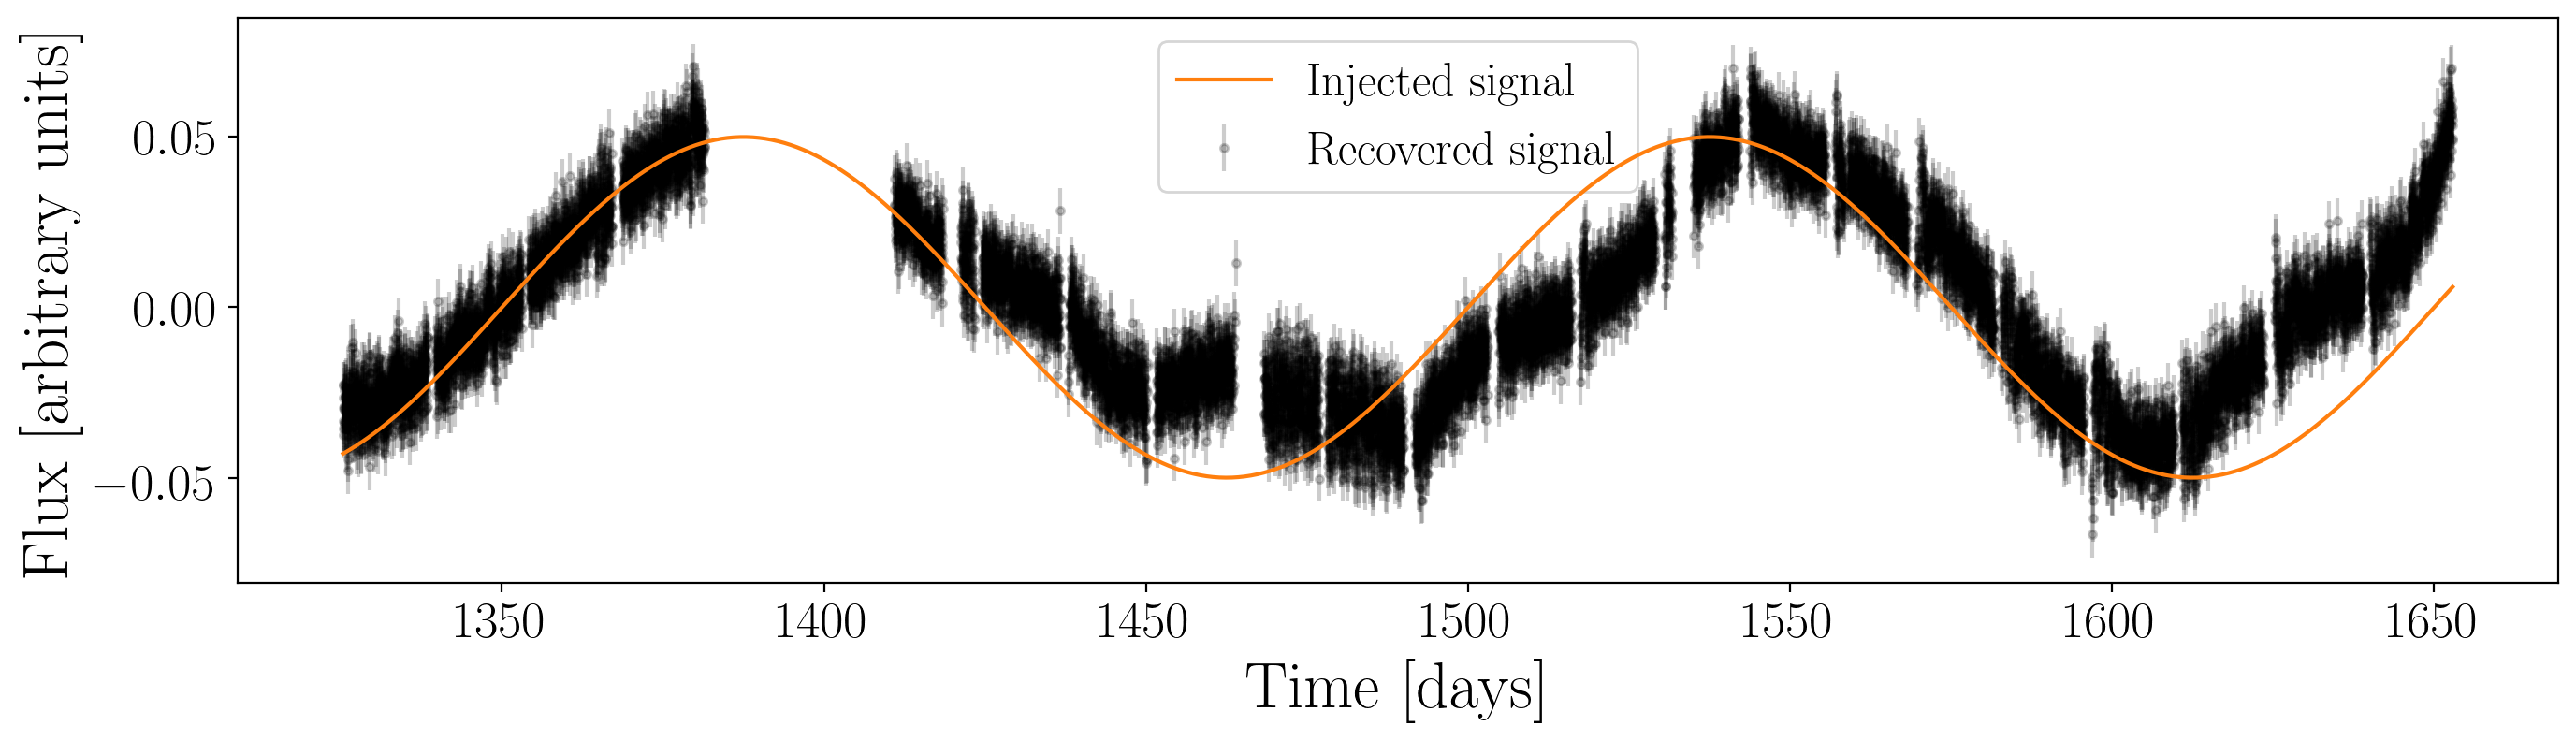

In [183]:
plt.figure(figsize=(16, 4), dpi=200)
p = np.polyfit(time150, flux150, 1)
xs = np.linspace(min(time150), max(time150), 1000)
plt.errorbar(time150, flux150-np.polyval(p, time150), yerr=flux_err150, fmt="k.", alpha=.2, label="$\mathrm{Recovered~signal}$")
plt.plot(xs, 0.05*np.sin(xs*2*np.pi/150), "C1", zorder=10, label="$\mathrm{Injected~signal}$")
plt.legend(loc="upper center", fontsize=18)
plt.xlabel("$\mathrm{Time~[days]}$")
plt.ylabel("$\mathrm{Flux~[arbitrary~units]}$");
plt.savefig("15th_150_day_injection")
plt.savefig("15th_150_day_injection.pdf")

In [242]:
def plot_ax(ax, time, flux, flux_err, period, maxp=period+50):
    rotate = ss.RotationModel(time, flux, flux_err)
    ls_period = rotate.ls_rotation(max_period=maxp)
    
    p = np.polyfit(time, flux, 1)
    fmt = "k."
    if period == 200:
        fmt="C3."
    ax.errorbar(time, flux-np.polyval(p, time), yerr=flux_err, fmt=fmt, alpha=.2,
                label=f"{ls_period:.1f} days", zorder=0, rasterized=True)
    xs = np.linspace(min(time), max(time), 1000)
    ax.plot(xs, 0.05*np.sin(xs*2*np.pi/period), "C1", zorder=2, label=f"{period} days")
    ax.set_yticklabels([])
    return ax

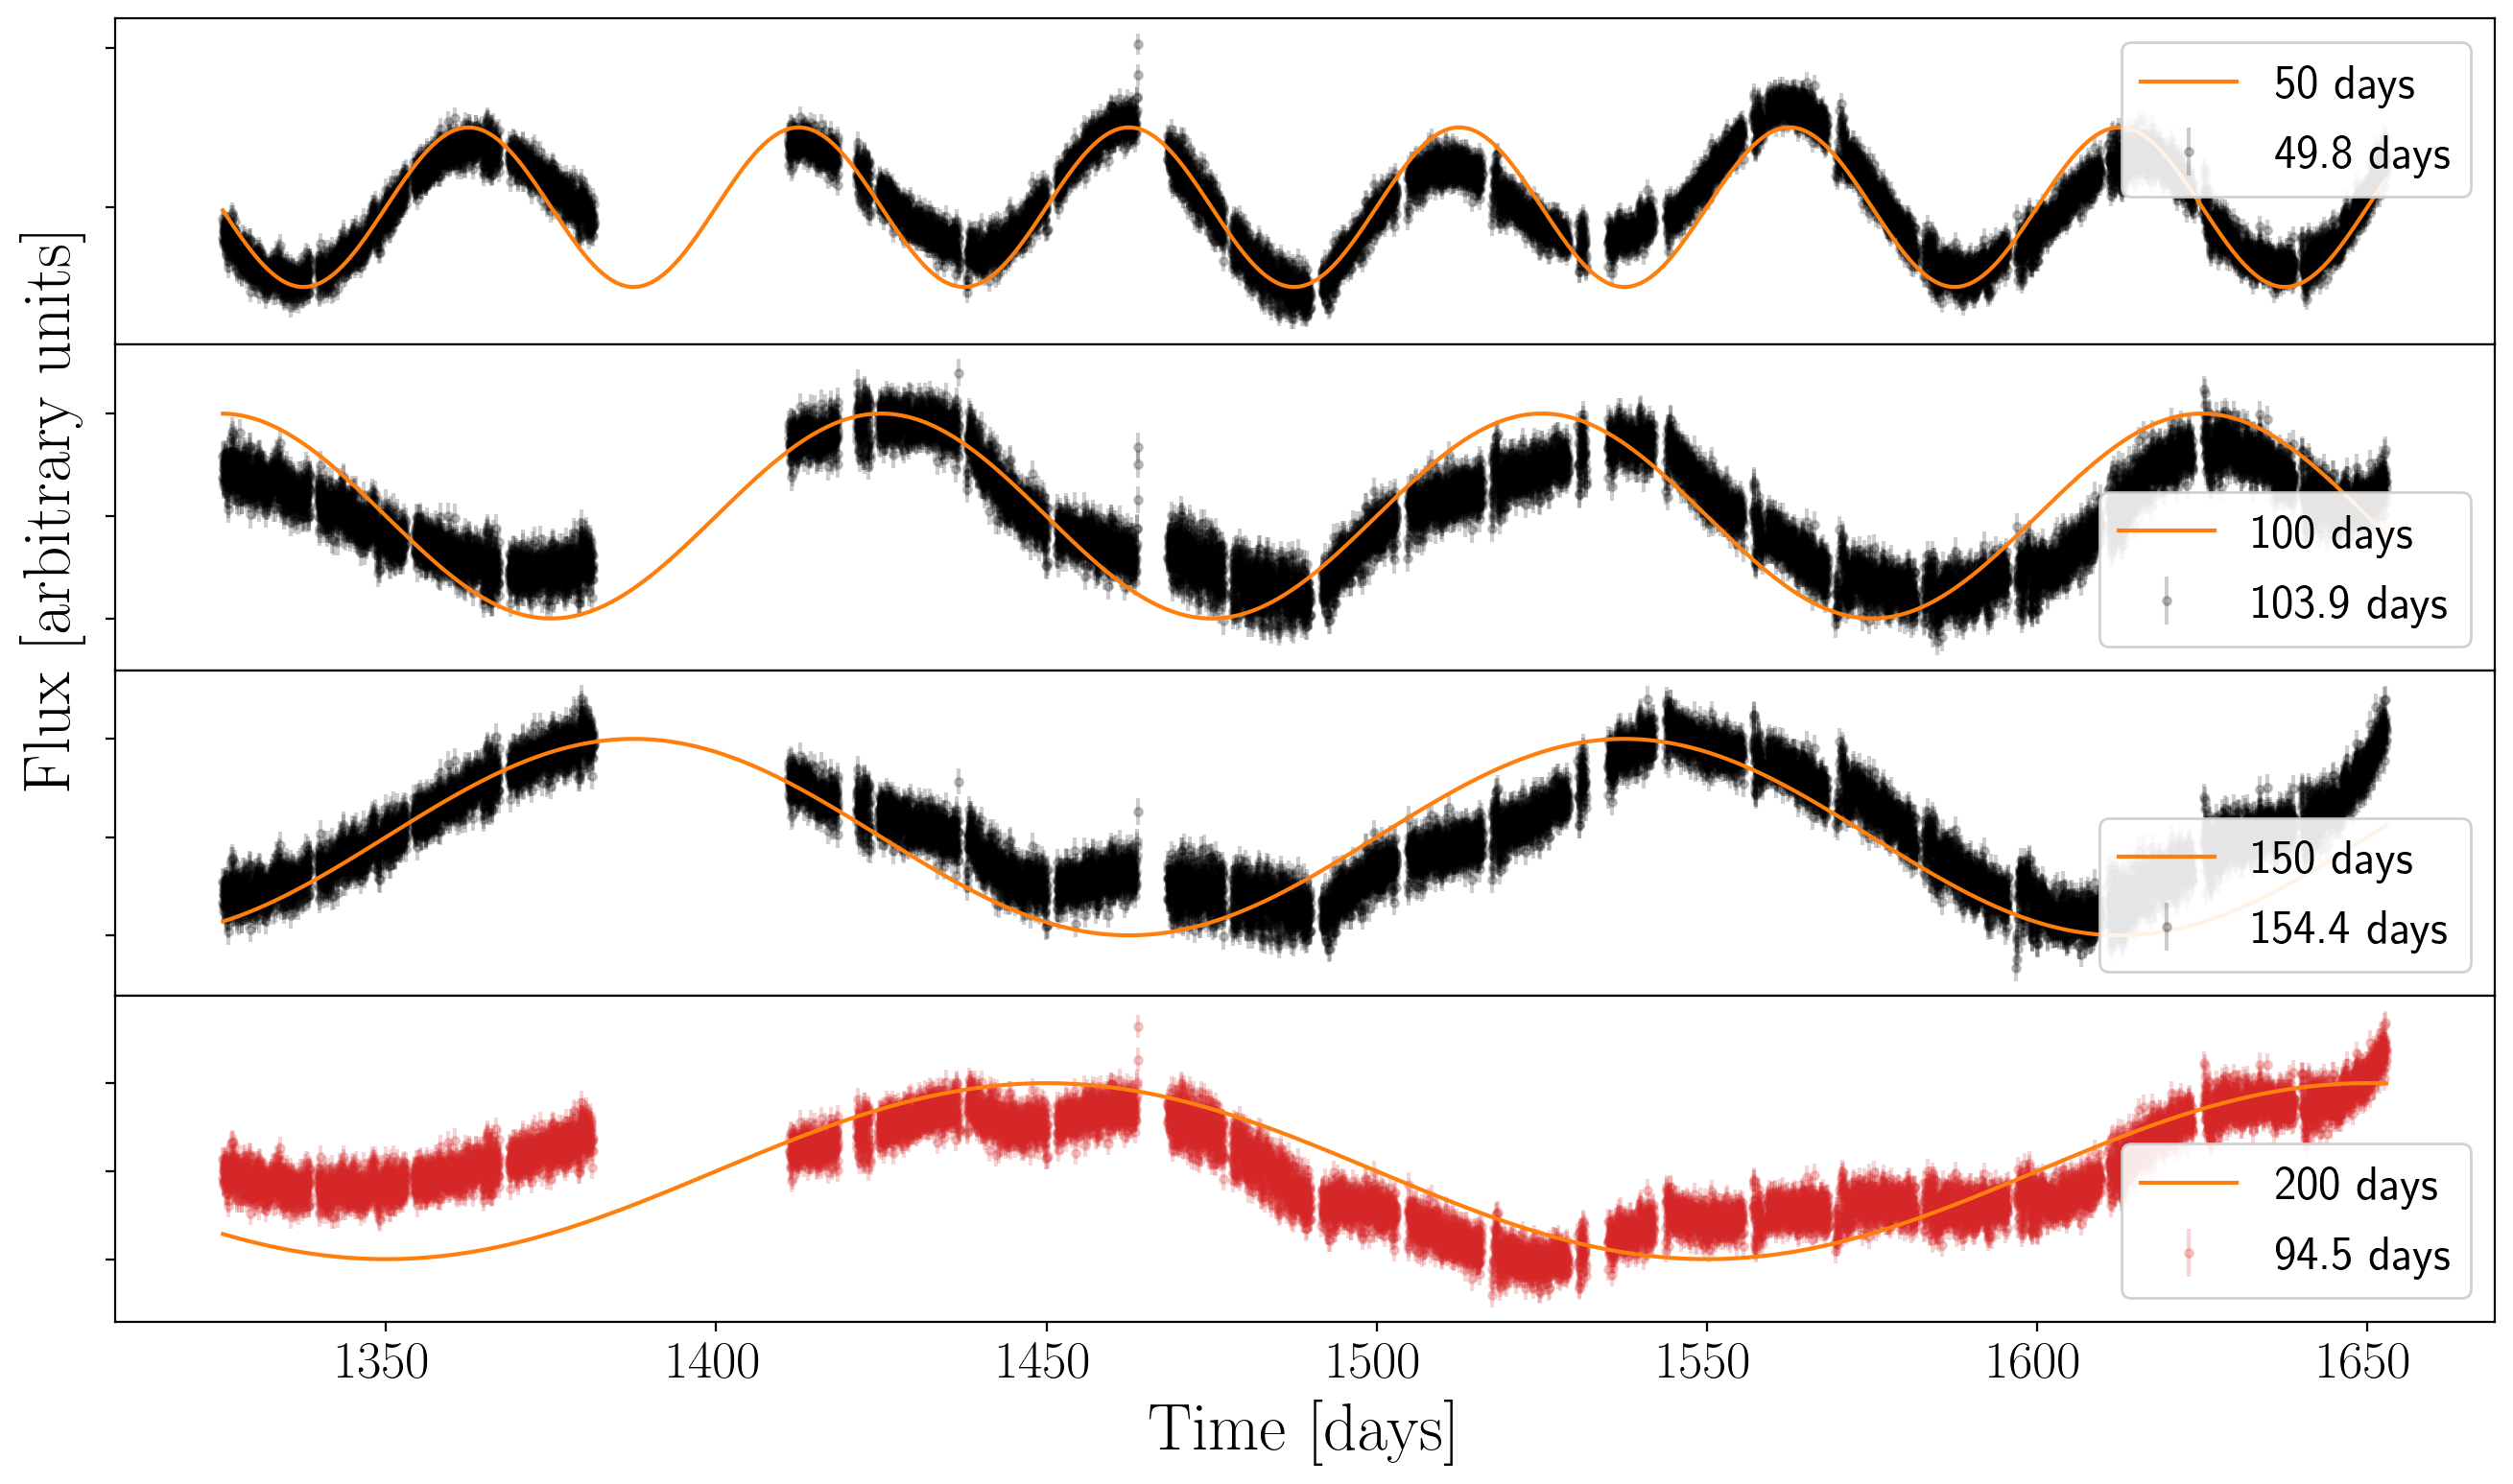

In [244]:
fig = plt.figure(figsize=(16, 9), dpi=200)

ax1 = fig.add_subplot(411)
ax1 = plot_ax(ax1, time, flux, flux_err, 50)
ax1.legend(loc="upper right", fontsize=18, framealpha=.9)
# ax1.legend(loc="upper center", fontsize=18)

ax2 = fig.add_subplot(412)
ax2 = plot_ax(ax2, time100, flux100, flux_err100, 100)
ax2.set_ylabel("$\mathrm{Flux~[arbitrary~units]}$");
ax2.legend(loc="lower right", fontsize=18, framealpha=.9)

ax3 = fig.add_subplot(413)
plot_ax(ax3, time150, flux150, flux_err150, 150)
ax3.legend(loc="lower right", fontsize=18, framealpha=.9)
ax3.set_xlabel("$\mathrm{Time~[days]}$")

ax4 = fig.add_subplot(414)
ax4 = plot_ax(ax4, time200, flux200, flux_err200, 200)
ax4.set_xlabel("$\mathrm{Time~[days]}$")
ax4.legend(loc="lower right", fontsize=18, framealpha=.9)

plt.subplots_adjust(hspace=0)
plt.savefig("injection_recovery")
plt.savefig("injection_recovery.pdf")